In [1]:
using LinearAlgebra
using Random
using StatsBase
using Plots
using Polynomials

In [2]:
# Questa funzione dovrebbe essere molto più veloce dell'implementazione ingenua, perché sfrutta
# il fatto che l'array sia ordinato.
# vedi qui https://discourse.julialang.org/t/findnearest-function/4143/3
function find_nearest(a,x)
       length(a) > 0 || return 0:-1
       r = searchsorted(a,x)
       length(r) > 0 && return r
       last(r) < 1 && return searchsorted(a,a[first(r)])
       first(r) > length(a) && return searchsorted(a,a[last(r)])
       x-a[last(r)] < a[first(r)]-x && return searchsorted(a,a[last(r)])
       x-a[last(r)] > a[first(r)]-x && return searchsorted(a,a[first(r)])
       return first(searchsorted(a,a[last(r)])):last(searchsorted(a,a[first(r)]))
end

function gillespie_fisher(H::Matrix{ComplexF64},
        Hp::Matrix{ComplexF64},
        Hm::Matrix{ComplexF64},
        M_l::Vector{Matrix{ComplexF64}},
        Mp_l::Vector{Matrix{ComplexF64}},
        Mm_l::Vector{Matrix{ComplexF64}},
        dθ::Float64,
        ψ0::Vector{ComplexF64},
        t_final::Float64,
        dt::Float64,
        number_trajectories::Int64,
        verbose::Bool=True)
    
    println("Gillespie-Fisher method in Julia - Welcome")
    println("=> Starting the pre-computation stage")
    t_range = 0.:dt:t_final
    
    # Constructs the overall jump operator.
    J = zero(M_l[1])
    for M in M_l
        J += M' * M
    end
    # Effective (non-Hermitian) Hamiltonian.
    He = H - 1im/2. * J
    
    # Constructs the no-jump evolution operators for all the relevant times.
    V = Matrix{ComplexF64}[] # List of the no-jump evolution operators.
    Qs = Matrix{ComplexF64}[] # List of the non-state-dependent part of the waiting time distribution.
    for t in t_range
        ev_op = exp(-1im * He * t)
        push!(V, ev_op)
        nsd_wtd = ev_op' * J * ev_op
        push!(Qs, nsd_wtd)
    end
    
    # Prints the matrix norm for the latest Qs.
    error = norm(last(Qs))
    println("-> Truncation error given by norm of latest Qs matrix: " * string(error))
    
    # Displaced version of the effective Hamiltonian.
    Jp = zero(Mp_l[1])
    for Mp in Mp_l
        Jp += Mp' * Mp
    end
    Hep = Hp - 1im/2. * Jp
    Jm = zero(Mm_l[1])
    for Mm in Mm_l
        Jm += Mm' * Mm
    end
    Hem = Hm - 1im/2. * Jm
    
    # Vector of the derivatives of the evolution operator wrt the parameter.
    Vdot = Matrix{ComplexF64}[]
    for t in t_range
        vd = (exp(-1im * Hep * t) - exp(-1im * Hem * t)) / (2 * dθ)
        push!(Vdot, vd)
    end
    # Derivatives of all the jump operators.
    Mdot = Matrix{ComplexF64}[]
    for n_M in eachindex(M_l)
        push!(Mdot, (Mp_l[n_M] - Mm_l[n_M]) / (2 * dθ))
    end
    # Precomputation of all the derivatives of MkV(t).
    Δ = Array{Matrix{ComplexF64}}[]
    for n_M in eachindex(M_l)
        fixed_M = Matrix{ComplexF64}[]
        for n_t in eachindex(t_range)
            obj = Mdot[n_M] * V[n_t] + M_l[n_M] * Vdot[n_t]
            push!(fixed_M, obj)
        end
        push!(Δ, fixed_M)
    end
    
    println("=> Starting the evolution cycle.")
    
    # List for the results.
    trajectories_results = Array{Dict{String, Any}}[]
    
    # Cycle over the trajectories.
    for trajectory in 1:number_trajectories
        if mod(trajectory, 100) == 0
            flush(stdout)
        end
        print(".")
        
        # Initial state.
        ψ = ψ0
        # Absolute time.
        τ = 0
        # Initial ξ matrix (same size and type as the Hamiltonian).
        ξ = zero(H)
        
        results = Dict{String, Any}[]
        dict_initial = Dict("AbsTime" => 0,
            "TimeSinceLast" => 0,
            "JumpChannel" => nothing,
            "ξAfter" => ξ,
            "ψAfter" => ψ0)
        push!(results, dict_initial)
        
        while τ < t_final
            dict_jump = Dict()
            
            # Pass to density matrix formalism.
            ρ = ψ * ψ'
            
            # Compute the waiting time distribution, exploiting the pre-computed part.
            Ps = Float64[]
            for Q in Qs
                wtd = real(ψ' * Q * ψ)
                push!(Ps, wtd)
            end
            
            # Sample from the waiting time distribution.
            n_T = sample(1:length(t_range), Weights(Ps))
            
            # Increase the absolute time.
            τ += t_range[n_T]
            merge!(dict_jump, Dict("AbsTime" => τ, "TimeSinceLast" => t_range[n_T]))
            
            # Update the state.
            ψ = V[n_T] * ψ
            # Chooses where to jump.
            weights = Float64[]
            for M in M_l
                weight = real(ψ' * M' * M * ψ)
                push!(weights, weight)
            end
            n_jump = sample(1:length(M_l), Weights(weights))
            merge!(dict_jump, Dict("JumpChannel" => n_jump))
            # Update the state after the jump.
            ψ = M_l[n_jump] * ψ
            norm_state = norm(ψ)
            # Renormalize the state.
            ψ = ψ / norm_state
            
            if verbose
                println(string(dict_jump))
            end
            
            # Compute the ξ matrix.
            ξ = 1/(norm_state^2) * (M_l[n_jump] * V[n_T] * ξ * (V[n_T])' * (M_l[n_jump])')
            ξ += 1/(norm_state^2) * (Δ[n_jump][n_T] * ρ * (V[n_T])' * (M_l[n_jump])')
            ξ += 1/(norm_state^2) * (M_l[n_jump] * V[n_T] * ρ * (Δ[n_jump][n_T])')
            trξ2 = real(tr(ξ))^2
            merge!(dict_jump, Dict("ξAfter" => ξ, "ψAfter" => ψ, "trξ2" => trξ2))
            push!(results, dict_jump)
        end
        
        push!(trajectories_results, results)
    end
    
    return trajectories_results, V, Vdot, t_range
end

function fisher_at_time_on_trajectory(t_range::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        relevant_times::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64},
        V::Vector{Matrix{ComplexF64}},
        Vdot::Vector{Matrix{ComplexF64}},
        trajectory_data::Vector{Dict{String, Any}},
        ψ0::Vector{ComplexF64})
    
    v_fisher = Float64[]
    
    # Creates an array of jump times.
    jump_times = [trajectory_data[i]["AbsTime"] for i in eachindex(trajectory_data)]
    # Creates an array of states after the jumps.
    ψ_after_jumps = [trajectory_data[i]["ψAfter"] for i in eachindex(trajectory_data)]
    # Creates an array of ξ after the jumps.
    ξ_after_jumps = [trajectory_data[i]["ξAfter"] for i in eachindex(trajectory_data)]
    
    # Cycles over the jumps times.
    for n_jump in 1:length(jump_times)-1
        next_jump_time = jump_times[n_jump + 1]
        # Determines the set of relevant times between this jump and the following one.
        relevant_times_in_interval = [t for t in t_range if jump_times[n_jump] <= t < next_jump_time]
        # Cycles over the relevant times.
        for t_abs in relevant_times_in_interval
            ψ = ψ_after_jumps[n_jump]
            ρ = ψ * ψ'
            ξ = ξ_after_jumps[n_jump]
            n_t = find_nearest(t_range, t_abs - jump_times[n_jump])[1]
            trace = real(tr(V[n_t] * ρ * (V[n_t])'))
            ξ = Vdot[n_t] * ρ * (V[n_t])' + V[n_t] * ρ * (Vdot[n_t])' + V[n_t] * ξ * (V[n_t])'
            ξ = ξ / trace
            fisher = real(tr(ξ))^2
            push!(v_fisher, fisher)
        end
    end
    
    # Now computes the ξ for all times after the latest jump.
    last_jump_absolute_time = last(jump_times)
    relevant_times_after_last_jump = [t for t in t_range if t >= last_jump_absolute_time]
    for t_abs in relevant_times_after_last_jump
        ψ = last(ψ_after_jumps)
        ρ = ψ * ψ'
        ξ = last(ξ_after_jumps)
        n_t = find_nearest(t_range, t_abs - last_jump_absolute_time)[1]
        trace = real(tr(V[n_t] * ρ * (V[n_t])'))
        ξ = Vdot[n_t] * ρ * (V[n_t])' + V[n_t] * ρ * (Vdot[n_t])' + V[n_t] * ξ * (V[n_t])'
        ξ = ξ / trace
        fisher = real(tr(ξ))^2
        push!(v_fisher, fisher)
    end
    
    return v_fisher
end

fisher_at_time_on_trajectory (generic function with 1 method)

In [3]:
# Model parameters.
ωA = 1.
ωB = 1.
ΩA = 0.
ΩB = 1.
γ = 0.1

# Initial state.
ψ0_A = complex(float([1 ; 0]))
ψ0_B = complex(float([1 ; 0]))
ψ0 = kron(ψ0_A, ψ0_B)

# Simulation parameters.
t_final = 50.
dt = 0.01
dω = 0.01
number_trajectories = 100
n_t_initial_fit = Int(floor(30. / dt))

# g-exploration parameters.
g_range = 0:0.05:1;

# Vector for the slopes.
v_slopes = []

Any[]

====>>>> STARTING FOR g = 0.0
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.011656836038551036
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

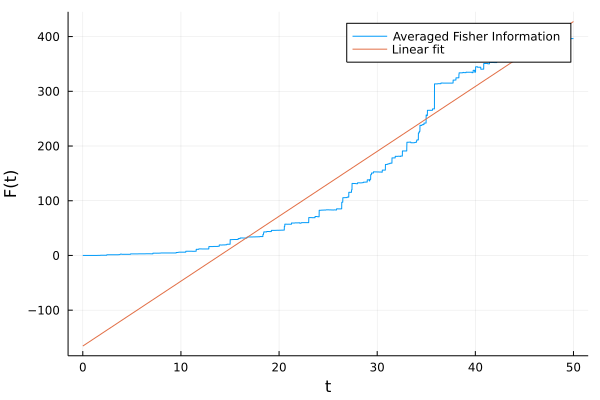

Found slope of 11.8607311616275

====>>>> STARTING FOR g = 0.05
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.011745981481948527
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

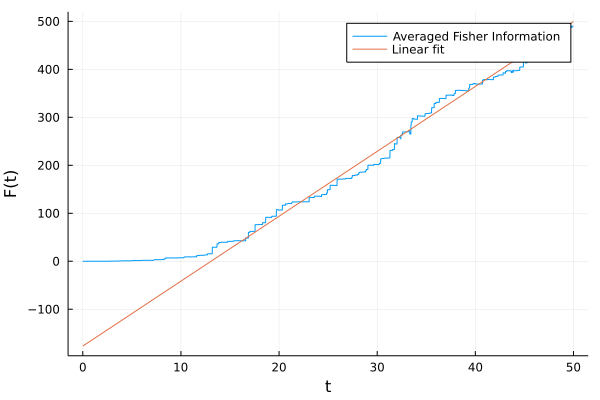

Found slope of 13.528112805829648

====>>>> STARTING FOR g = 0.1
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.01199907362700731
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

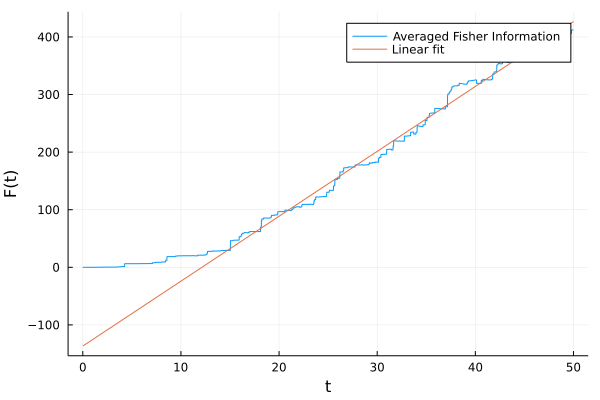

Found slope of 11.269089598846458

====>>>> STARTING FOR g = 0.15
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.012354480195203894
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

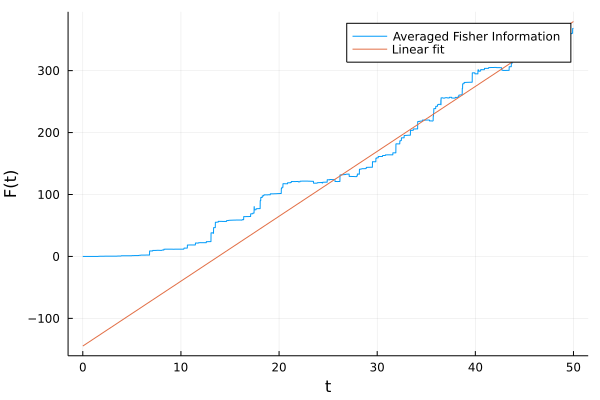

Found slope of 10.477532968194225

====>>>> STARTING FOR g = 0.2
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.012693689410555061
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

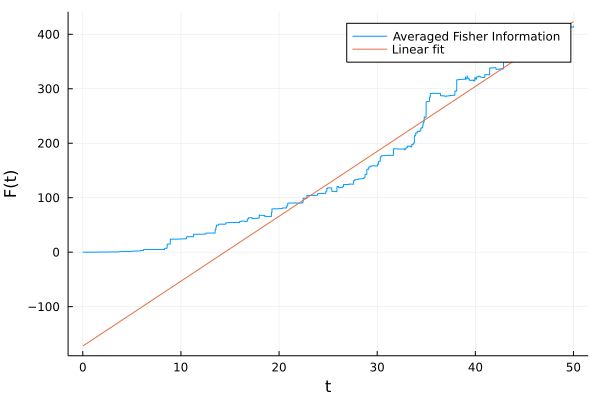

Found slope of 11.914844100179577

====>>>> STARTING FOR g = 0.25
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.012978273512689556
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

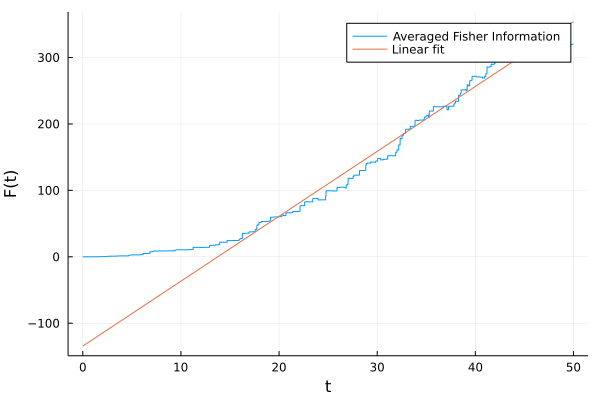

Found slope of 9.769138809625945

====>>>> STARTING FOR g = 0.3
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.013270963008160516
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

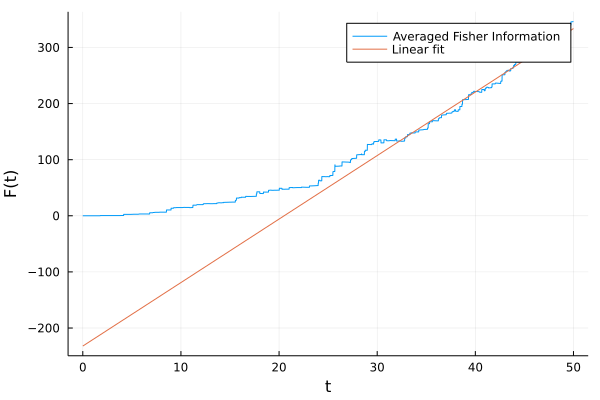

Found slope of 11.31669753180098

====>>>> STARTING FOR g = 0.35
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.013448466332977914
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

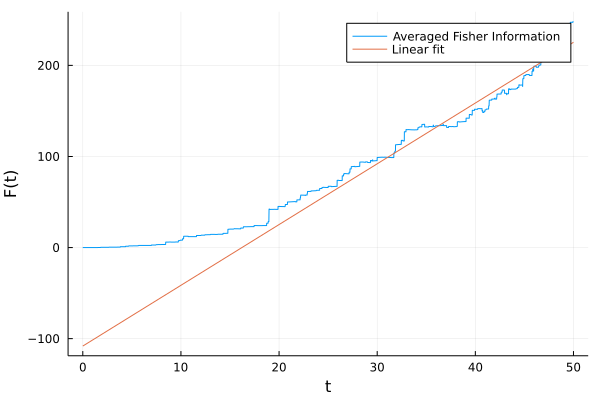

Found slope of 6.66993891072283

====>>>> STARTING FOR g = 0.4
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.013797640089537619
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

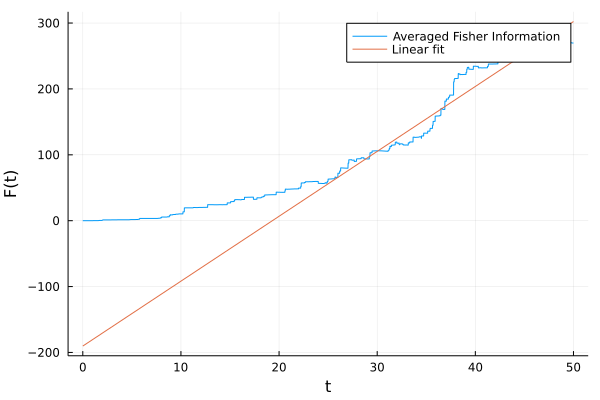

Found slope of 9.852851002351656

====>>>> STARTING FOR g = 0.45
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.014296462908308945
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

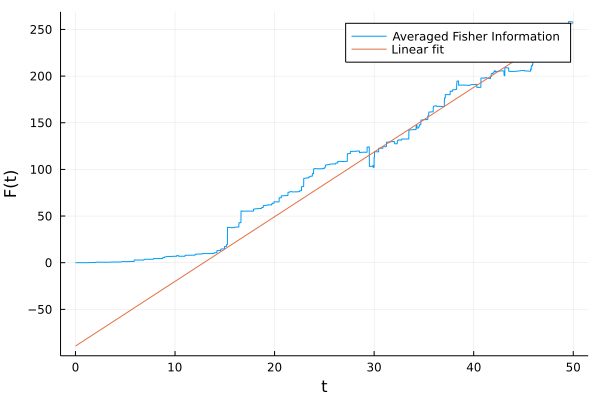

Found slope of 6.9320862379676855

====>>>> STARTING FOR g = 0.5
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.01430581045528546
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

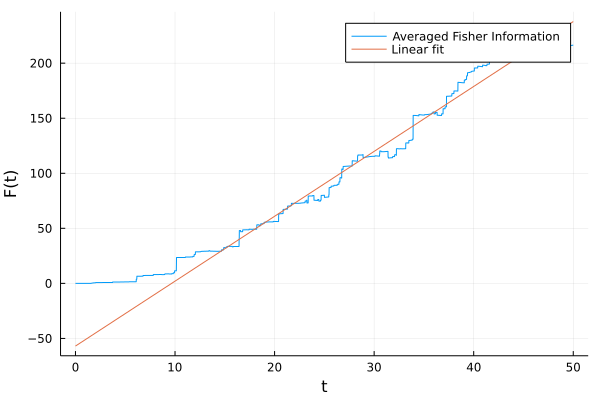

Found slope of 5.894741006628647

====>>>> STARTING FOR g = 0.55
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.01445260822477112
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

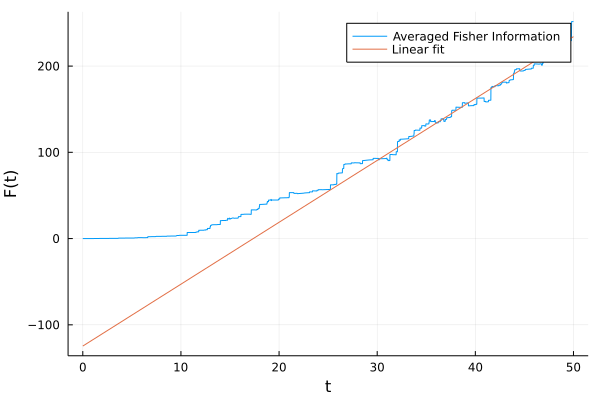

Found slope of 7.176375049503737

====>>>> STARTING FOR g = 0.6
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.014429690725585491
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

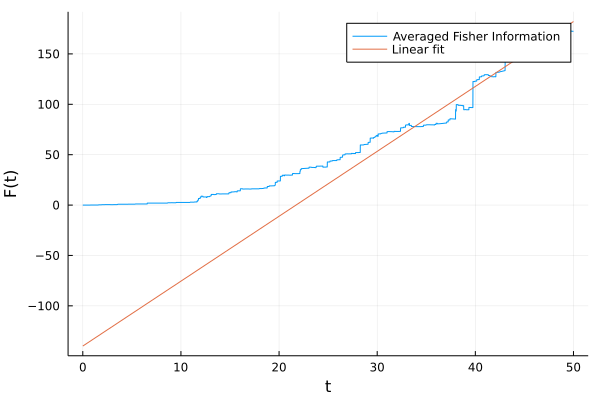

Found slope of 6.439724202882349

====>>>> STARTING FOR g = 0.65
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.014799415088548724
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

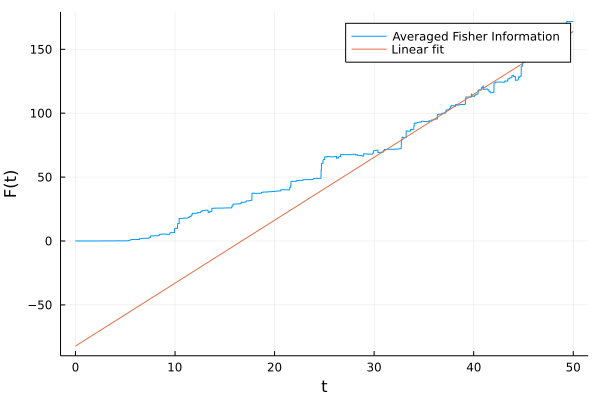

Found slope of 4.924257965230125

====>>>> STARTING FOR g = 0.7
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.014769206524749195
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

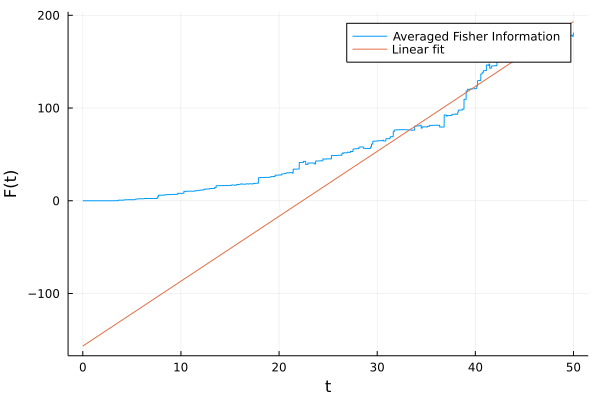

Found slope of 6.998596169445978

====>>>> STARTING FOR g = 0.75
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.015019889350115645
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

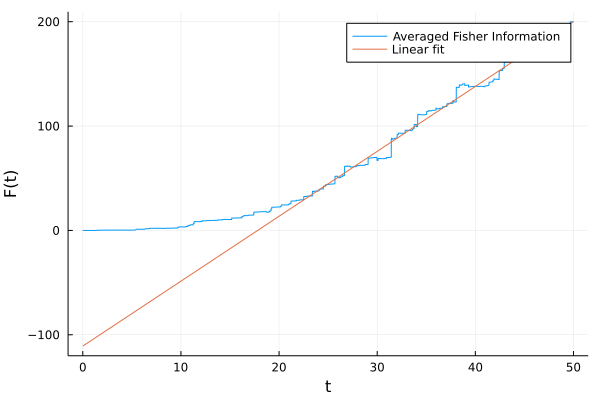

Found slope of 6.21992446894044

====>>>> STARTING FOR g = 0.8
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.014958718714283259
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

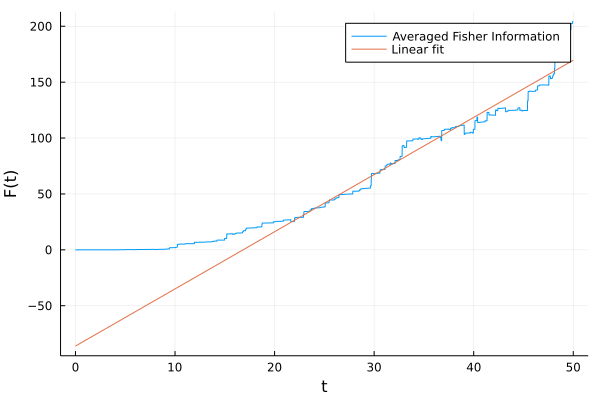

Found slope of 5.11432326017119

====>>>> STARTING FOR g = 0.85
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.01498294951855818
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

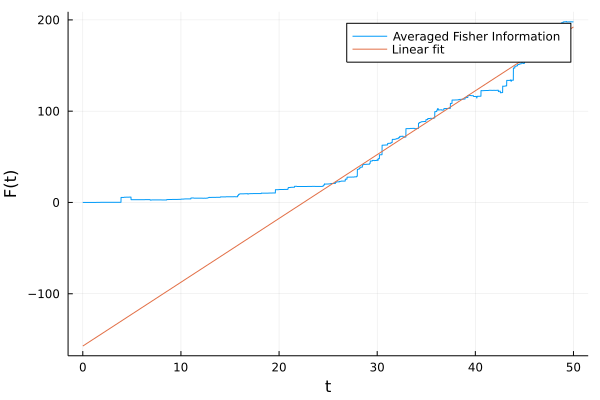

Found slope of 6.991362106500704

====>>>> STARTING FOR g = 0.9
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.014920769701463736
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

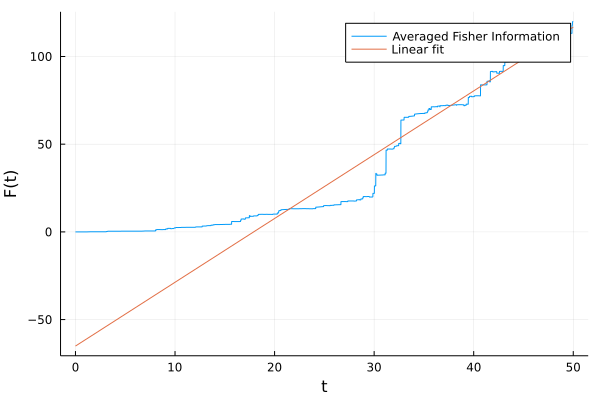

Found slope of 3.6368368855147115

====>>>> STARTING FOR g = 0.95
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.015410965925112992
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

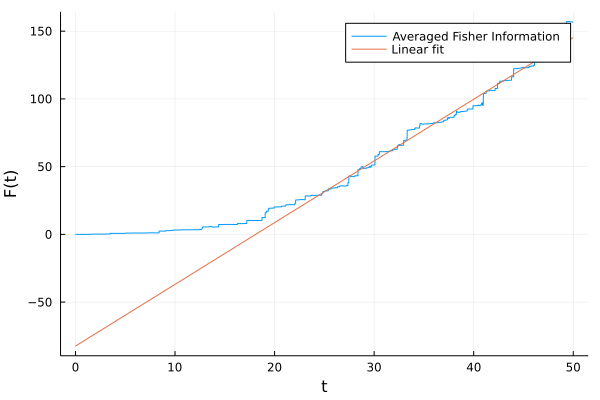

Found slope of 4.554887272212294

====>>>> STARTING FOR g = 1.0
Gillespie-Fisher method in Julia - Welcome
=> Starting the pre-computation stage
-> Truncation error given by norm of latest Qs matrix: 0.015324004935700034
=> Starting the evolution cycle.
....................................................................................................
Starting to fill the gaps.
....................................................................................................

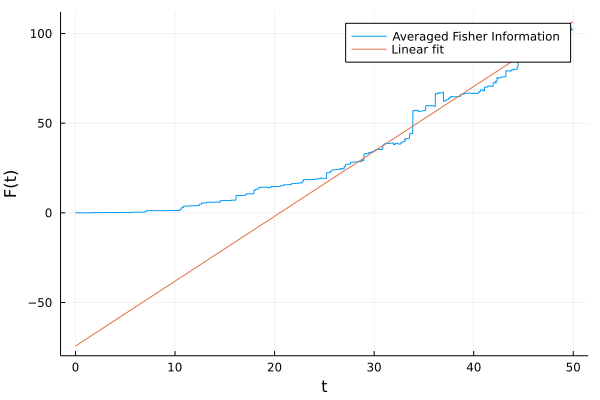

Found slope of 3.6197397779024305



In [4]:
for g in g_range
    flush(stdout)
    println("====>>>> STARTING FOR g = " * string(g))
    
    # Operators.
    σ = complex(float([0 1 ; 0 0]))
    σz = complex(float([1 0 ; 0 -1]))
    ide = complex(float([1 0 ; 0 1]))
    σx = σ + σ'
    # Tensorized versions.
    σ_A = kron(σ, ide)
    σ_B = kron(ide, σ)
    σx_A = kron(σx, ide)
    σx_B = kron(ide, σx)
    σz_A = kron(σz, ide)
    σz_B = kron(ide, σz)

    # Hamiltonian.
    H = ωA * σz_A + ωB * σz_B + ΩA * σx_A + ΩB * σx_B + g * (σ_A * σ_B' + σ_A' * σ_B)
    # Displaced versions.
    Hp = ωA * σz_A + (ωB + dω) * σz_B + ΩA * σx_A + ΩB * σx_B + g * (σ_A * σ_B' + σ_A' * σ_B)
    Hm = ωA * σz_A + (ωB - dω) * σz_B + ΩA * σx_A + ΩB * σx_B + g * (σ_A * σ_B' + σ_A' * σ_B)

    # Jump operator.
    M = sqrt(γ) * σ_B
    # The jump operator does not depend on the parameter.
    Mp = M
    Mm = M

    # The jump operators have to be passed as lists.
    M_l = [M]
    Mp_l = [Mp]
    Mm_l = [Mm];
    
    # Launches the Gillespie-Fisher simulation.
    trajectories_results, V, Vdot, t_range = gillespie_fisher(H, Hp, Hm, M_l, Mp_l, Mm_l, dω, ψ0, t_final, dt, number_trajectories, false)

    average_fisher = zeros(length(t_range))
    println()
    println("Starting to fill the gaps.")
    for n_trajectory in eachindex(trajectories_results)
        print(".")
        if mod(n_trajectory, 100) == 0
            flush(stdout)
        end
        v_fisher = fisher_at_time_on_trajectory(t_range, t_range, V, Vdot, trajectories_results[n_trajectory], ψ0)
        average_fisher += v_fisher / number_trajectories
    end

    plot(t_range, average_fisher, label="Averaged Fisher Information", xlabel="t", ylabel="F(t)")
    
    linear_fit = Polynomials.fit(t_range[n_t_initial_fit:end], average_fisher[n_t_initial_fit:end], 1)
    display(plot!(linear_fit, t_range[1], t_range[end],label="Linear fit"))
    slope = linear_fit[1]
    println("Found slope of " * string(slope))
    println()
    push!(v_slopes, slope)
end

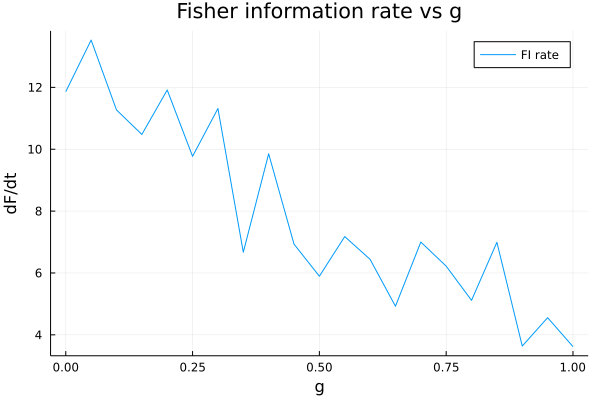

In [5]:
plot(g_range, v_slopes, title="Fisher information rate vs g", label="FI rate", xlabel="g", ylabel="dF/dt")